In [1]:
import numpy as np
import pandas as pd
from skew_autotransform import skew_autotransform
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

In [2]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


weather_df.head(10)

date        summary preciptype  temperature  \
0 2006-03-31 22:00:00+00:00  Partly Cloudy       rain     9.472222   
1 2006-03-31 23:00:00+00:00  Partly Cloudy       rain     9.355556   
2 2006-04-01 00:00:00+00:00  Mostly Cloudy       rain     9.377778   
3 2006-04-01 01:00:00+00:00  Partly Cloudy       rain     8.288889   
4 2006-04-01 02:00:00+00:00  Mostly Cloudy       rain     8.755556   
5 2006-04-01 03:00:00+00:00  Partly Cloudy       rain     9.222222   
6 2006-04-01 04:00:00+00:00  Partly Cloudy       rain     7.733333   
7 2006-04-01 05:00:00+00:00  Partly Cloudy       rain     8.772222   
8 2006-04-01 06:00:00+00:00  Partly Cloudy       rain    10.822222   
9 2006-04-01 07:00:00+00:00  Partly Cloudy       rain    13.772222   

   apparenttemperature  humidity  windspeed  windbearing  visibility  \
0             7.388889      0.89    14.1197        251.0     15.8263   
1             7.227778      0.86    14.2646        259.0     15.8263   
2             9.377778      0.89     3.9284        204.0     14.9569   
3             5.944444      0.83    14.1036        269.0     15.8263   
4             6.977778      0.83    11.0446        259.0     15.8263   
5             7.111111      0.85    13.9587        258.0     14.9569   
6             5.522222      0.95    12.3648        259.0      9.9820   
7             6.527778      0.89    14.1519        260.0      9.9820   
8            10.822222      0.82    11.3183        259.0      9.9820   
9            13.772222      0.72    12.5258        279.0      9.9820   

   loudcover  pressure                       dailysummary  
0        0.0   1015.13  Partly cloudy throughout the day.  
1        0.0   1015.63  Partly cloudy throughout the day.  
2        0.0   1015.94  Partly cloudy throughout the day.  
3        0.0   1016.41  Partly cloudy throughout the day.  
4        0.0   1016.51  Partly cloudy throughout the day.  
5        0.0   1016.66  Partly cloudy throughout the day.  
6        0.0   1016.72  Partly cloudy throughout the day.  
7        0.0   1016.84  Partly cloudy throughout the day.  
8        0.0   1017.37  Partly cloudy throughout the day.  
9        0.0   1017.22  Partly cloudy throughout the day.


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'temperature' . Skewness = 0.09


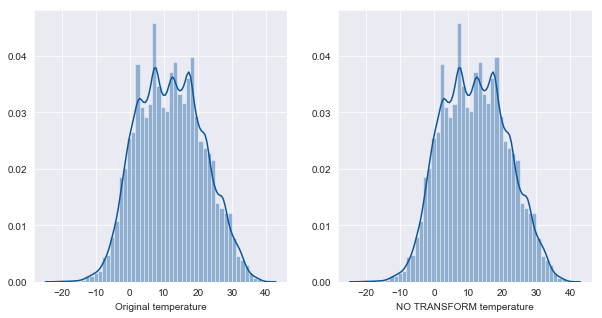


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'apparenttemperature' . Skewness = -0.06


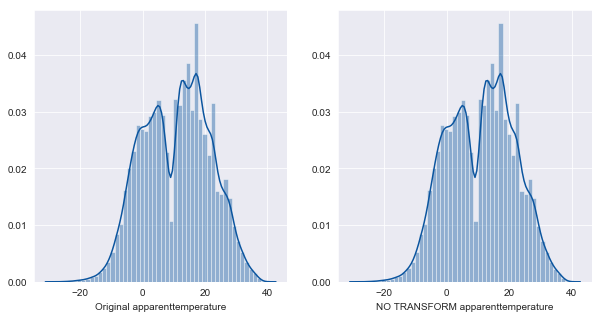


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'humidity' . Skewness = -0.72


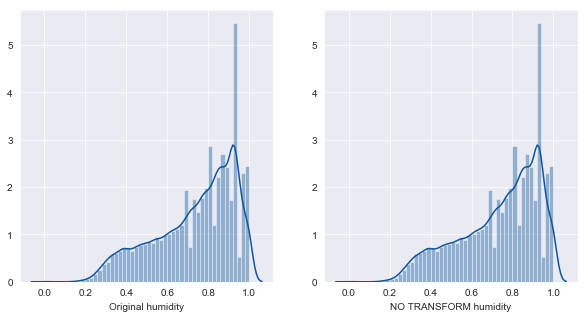


 ------------------------------------------------------

 'windspeed' had 'positive' skewness of 1.11

 Transformation yielded skewness of -0.00


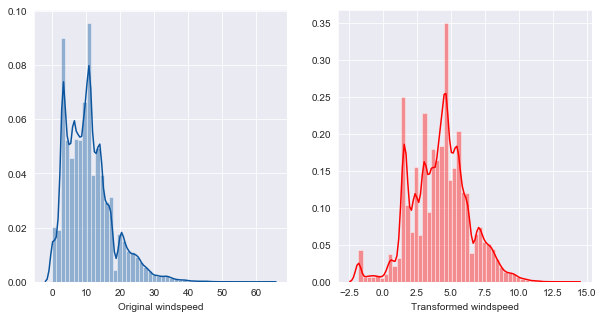


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'windbearing' . Skewness = -0.15


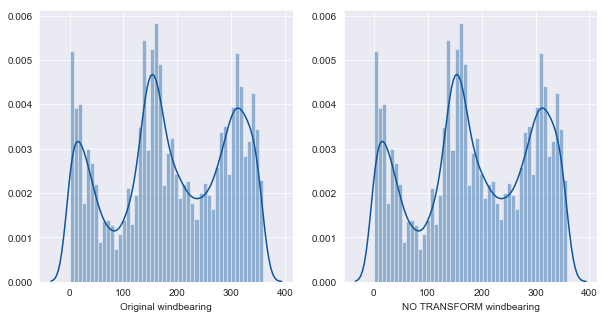


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'visibility' . Skewness = -0.50


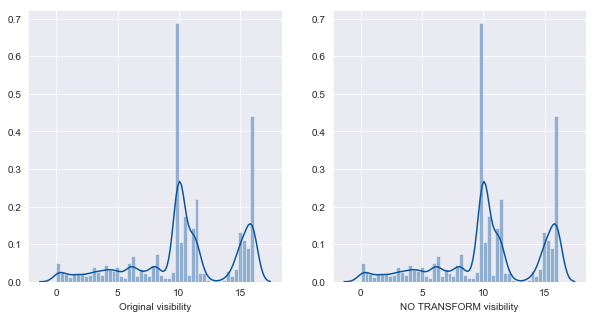


 ------------------------------------------------------

 NO TRANSFORMATION APPLIED FOR 'loudcover' . Skewness = 0.00


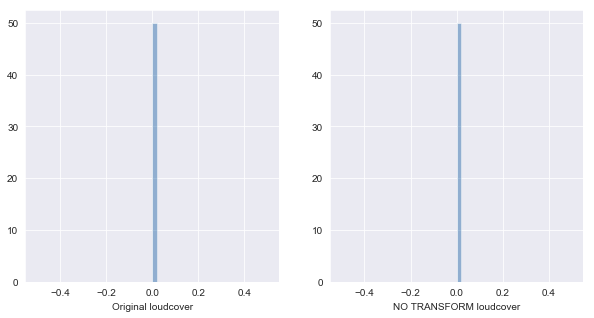


 ------------------------------------------------------

 'pressure' had 'negative' skewness of -8.42

 Transformation yielded skewness of -6.90


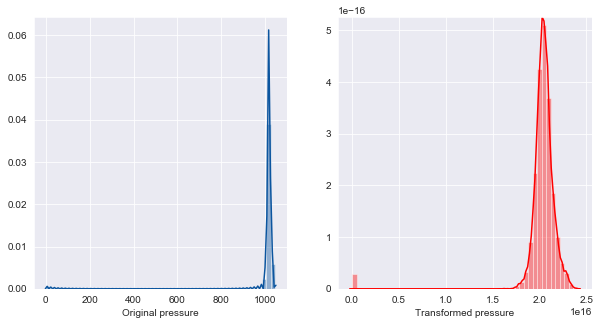

In [3]:
# check for skewness and normality
weather_df2 = skew_autotransform.skew_autotransform(weather_df.copy(deep=True), plot = True, exclude=('date','summary','preciptype', 'dailysummary'))


In [4]:
# Feature engineering for model
weather_df3 = weather_df2.loc[:, ('humidity', 'windspeed')]
weather_df3['apparentdifference'] =  weather_df2['apparenttemperature'] - weather_df2['temperature']

corr = weather_df3.corr()
corr.style.background_gradient(cmap='RdBu_r')

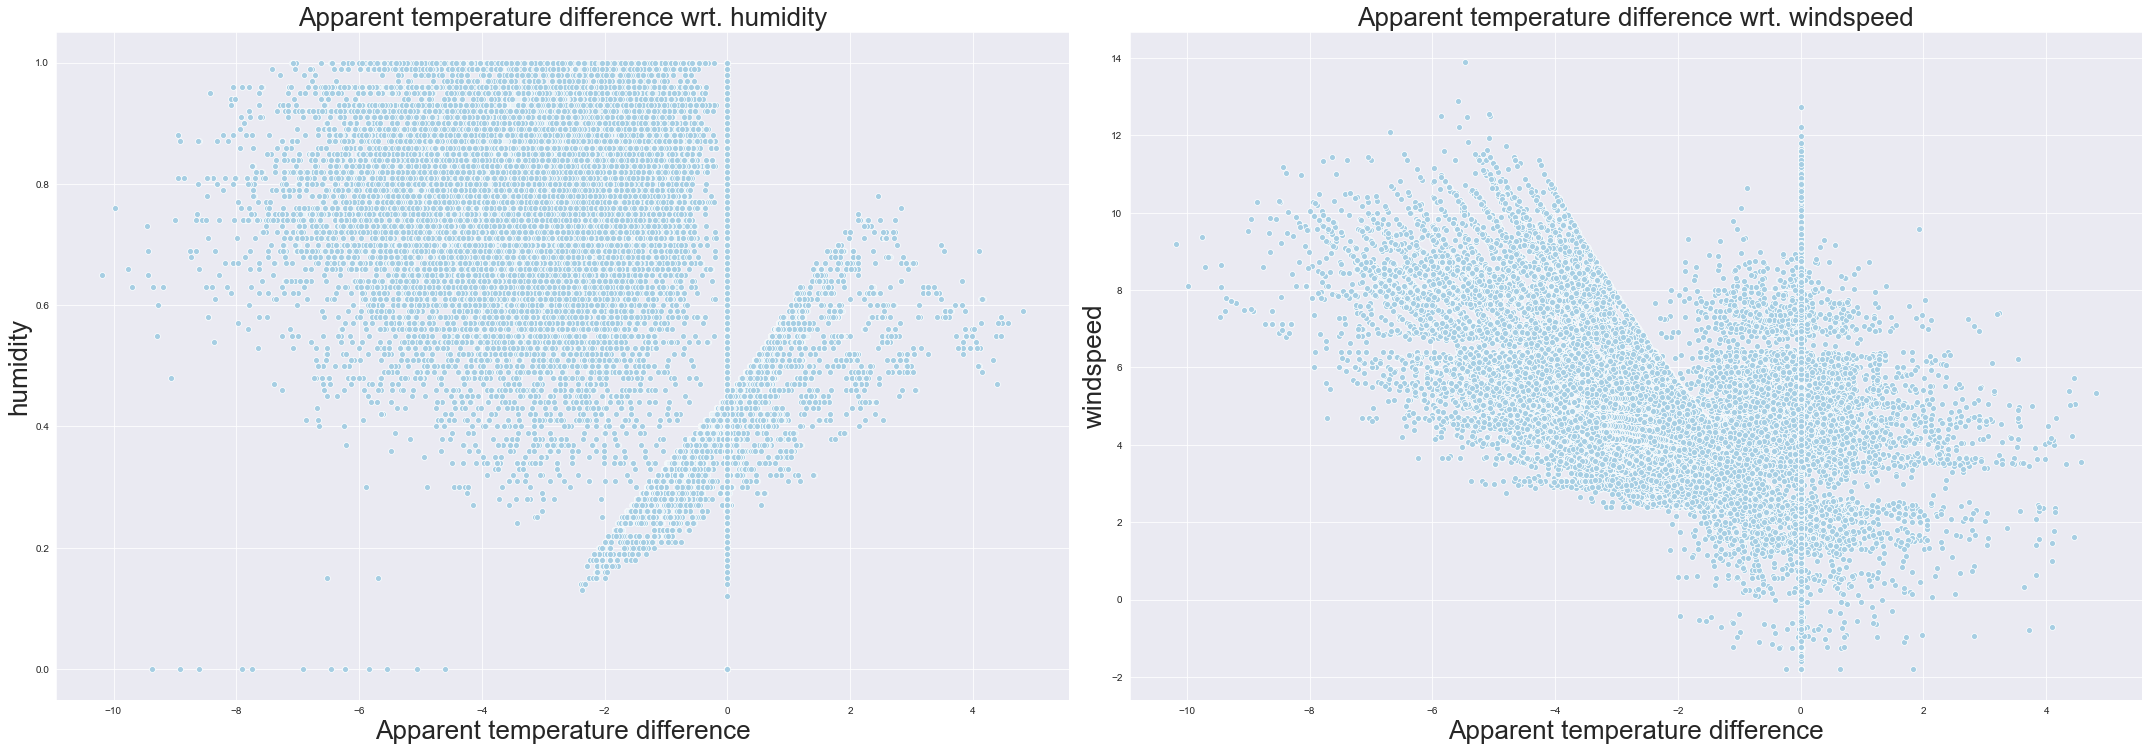

In [5]:
# visualize differences in temperature accross the different explanatory variables
plt.figure(figsize=(30,30))

cols = weather_df3.columns[:-1]
for index, column in enumerate(cols):
    plt.subplot(3,2,index+1)
    sns.scatterplot(y=column, x='apparentdifference', data=weather_df3)
    plt.title('Apparent temperature difference wrt. {}'.format(column), size=26)
    plt.xlabel('Apparent temperature difference', size=26)
    plt.ylabel(column, size=26)

plt.tight_layout()

plt.show()

## SciKit Learn model

In [6]:
target = weather_df3['apparentdifference']
data = weather_df3[cols]

# Initialize linear regression model
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(data, target)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


Coefficients: 
 [-3.06917536 -0.39160938]

Intercept: 
 2.8233502573249476


Estimated model:

$$ Apparent temperature difference = 0.15 +0.47*Humidity +0.22*Windspeed -0.83*Humidity*Windspeed\qquad$$

## 1. Initial model summary

In [7]:
sm_data = sm.add_constant(data)

results = sm.OLS(target, sm_data).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     apparentdifference   R-squared:                       0.294
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                 2.011e+04
Date:                Fri, 30 Aug 2019   Prob (F-statistic):               0.00
Time:                        01:53:16   Log-Likelihood:            -1.7001e+05
No. Observations:               96453   AIC:                         3.400e+05
Df Residuals:                   96450   BIC:                         3.401e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8234      0.022    127.969      0.000       2.780       2.867
humidity      -3.0692      0.024   -128.557      0.000      -3.116      -3.022
windspeed     -0.3916      0.002   -179.473      0.000      -0.396      -0.387
==============================================================================
Omnibus:                     4425.767   Durbin-Watson:                   0.278
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5135.444
Skew:                          -0.528   Prob(JB):                         0.00
Kurtosis:                       3.404   Cond. No.                         33.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Model improvement
## 2.1. Split model into two models based on bimodal apparent temperature distribution

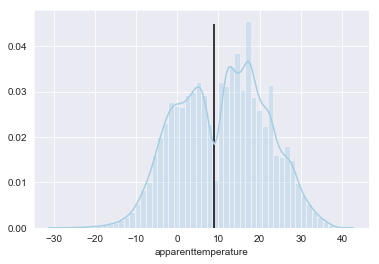

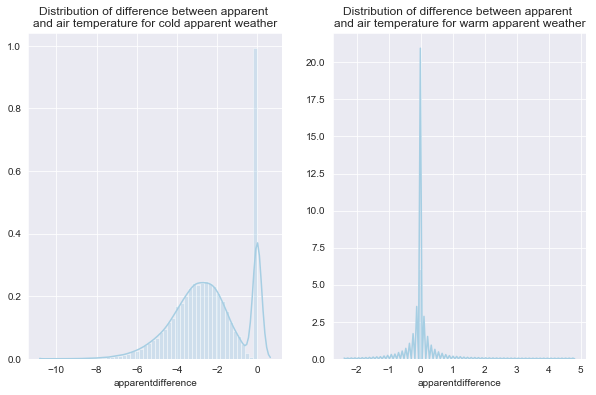

In [8]:
# apparent temp distribution
cutoff = 9
sns.distplot(weather_df2['apparenttemperature'])
plt.vlines(x=cutoff, ymin=0, ymax=0.045)
plt.show()

weather_df_cold = weather_df3[weather_df2['apparenttemperature'] < cutoff]
weather_df_warm = weather_df3[weather_df2['apparenttemperature'] >= cutoff]

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.distplot(weather_df_cold['apparentdifference'])
plt.title('Distribution of difference between apparent \nand air temperature for cold apparent weather')
plt.subplot(1,2,2)
sns.distplot(weather_df_warm['apparentdifference'])
plt.title('Distribution of difference between apparent \nand air temperature for warm apparent weather')
plt.show()

The right peak in the cold weather temperature differences plot, which is similar to the peak in warm weathers, does not disappar even when the cutoff is lowered/ increased by 5 degrees. This is simply reflective of situation where factors that lead to changing the felt temp do not exist (wind and humidity among others).

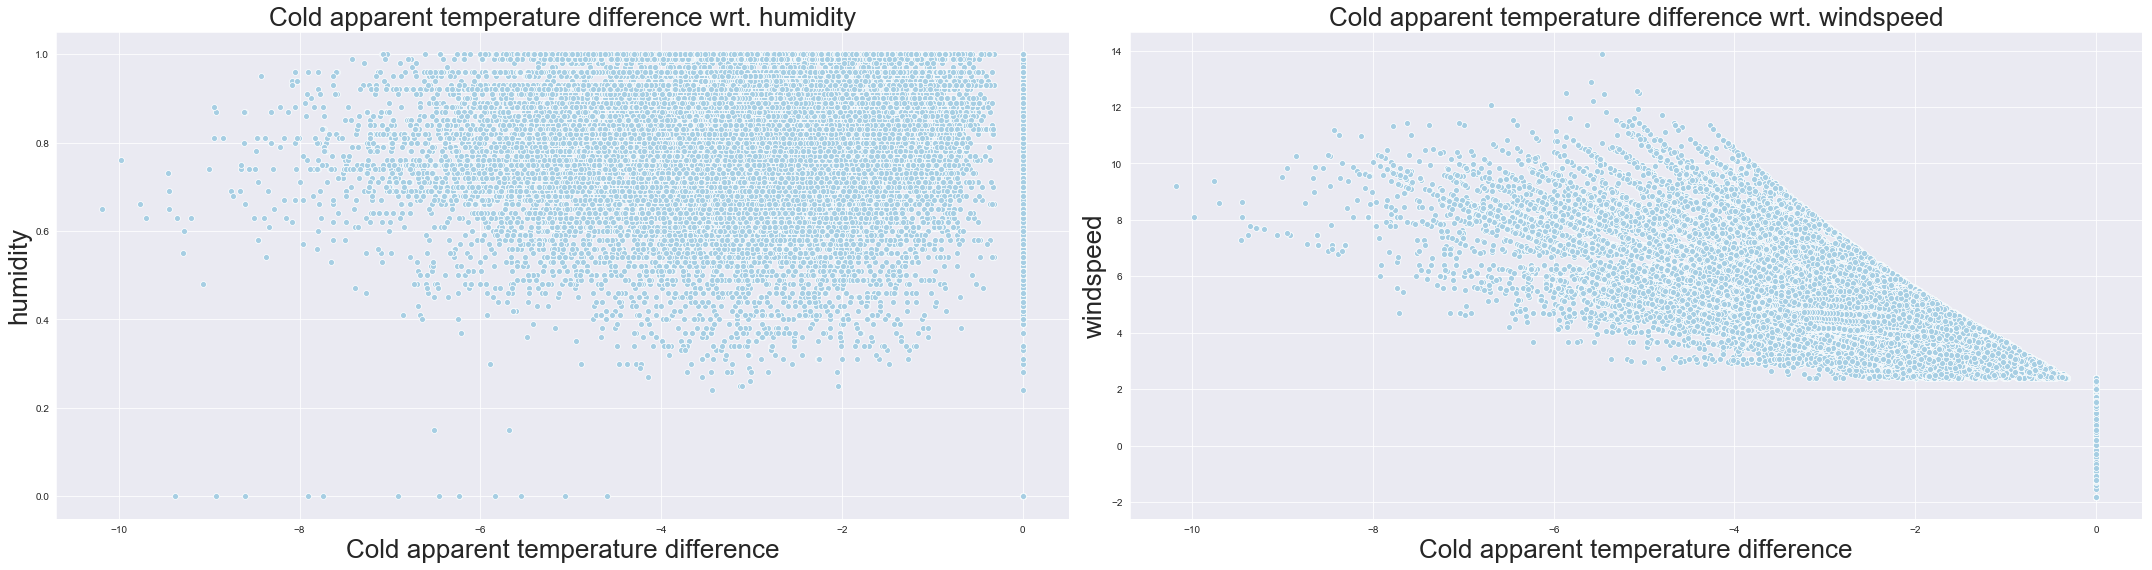

In [9]:
# visualize differences in cold apparent temps
plt.figure(figsize=(30,30))

cols = weather_df_cold.columns[:-1]
for index, column in enumerate(cols):
    plt.subplot(4,2,index+1)
    sns.scatterplot(y=column, x='apparentdifference', data=weather_df_cold)
    plt.title('Cold apparent temperature difference wrt. {}'.format(column), size=26)
    plt.xlabel('Cold apparent temperature difference', size=26)
    plt.ylabel(column, size=26)

plt.tight_layout()
plt.show()

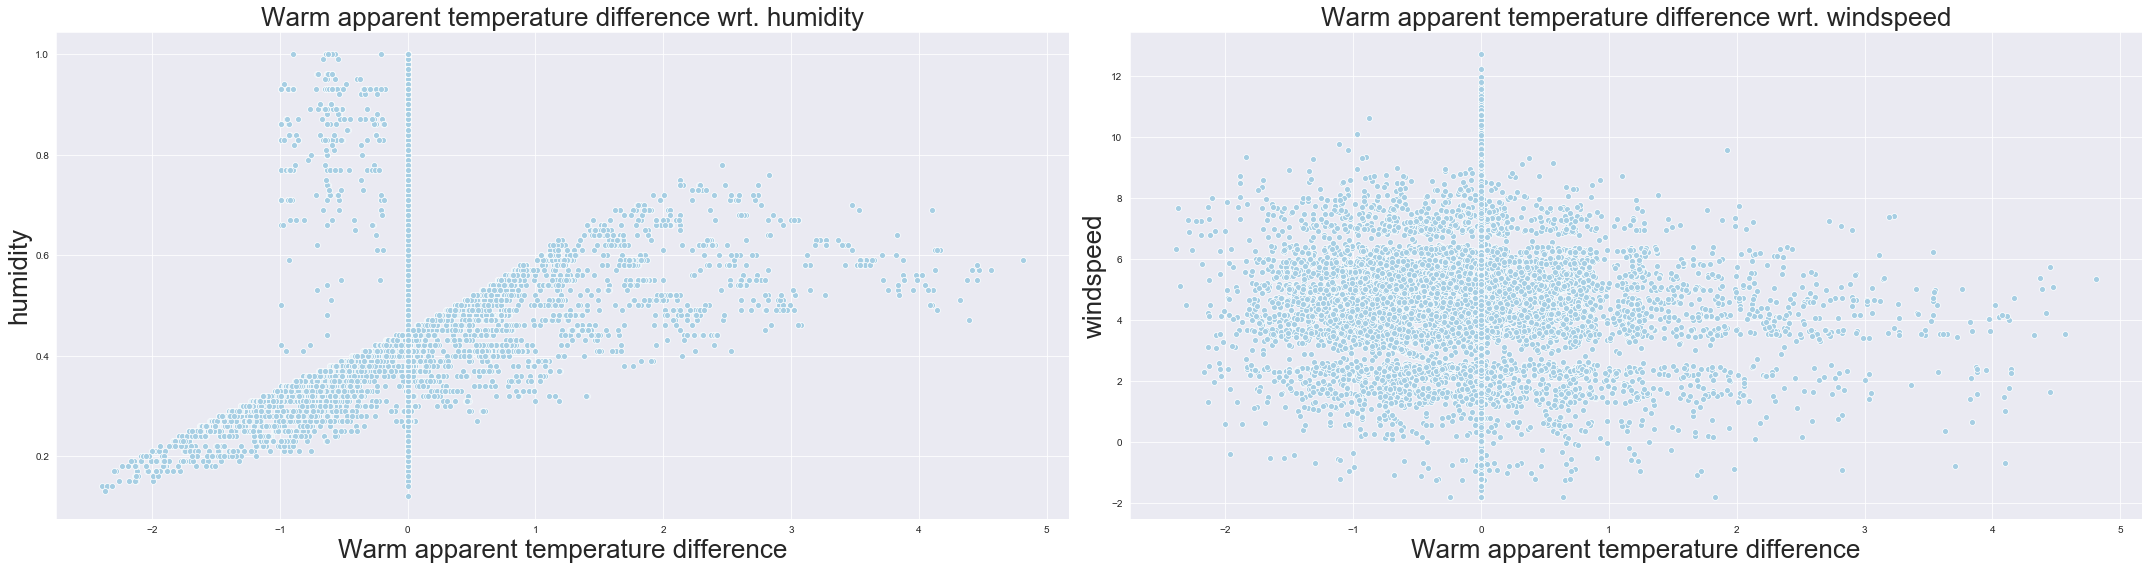

In [10]:
# visualize differences in warm apparent temps
plt.figure(figsize=(30,30))

cols = weather_df_warm.columns[:-1]
for index, column in enumerate(cols):
    plt.subplot(4,2,index+1)
    sns.scatterplot(y=column, x='apparentdifference', data=weather_df_warm)
    plt.title('Warm apparent temperature difference wrt. {}'.format(column), size=26)
    plt.xlabel('Warm apparent temperature difference', size=26)
    plt.ylabel(column, size=26)

plt.tight_layout()
plt.show()

In [11]:
## 2.2. Modified models

In [12]:
# Split model
## cold apparent weather
target = weather_df_cold['apparentdifference']
data = weather_df_cold[cols]

sm_data = sm.add_constant(data)

results = sm.OLS(target, sm_data).fit()
print('Cold apparent weather model summary:\n',results.summary())

## warm apparent weather
target = weather_df_warm['apparentdifference']
data = weather_df_warm[cols]

sm_data = sm.add_constant(data)

results = sm.OLS(target, sm_data).fit()
print('\n**************************************************\nWarm apparent weather model summary:\n',results.summary())

Cold apparent weather model summary:
                             OLS Regression Results                            
Dep. Variable:     apparentdifference   R-squared:                       0.703
Model:                            OLS   Adj. R-squared:                  0.703
Method:                 Least Squares   F-statistic:                 4.956e+04
Date:                Fri, 30 Aug 2019   Prob (F-statistic):               0.00
Time:                        01:53:24   Log-Likelihood:                -56778.
No. Observations:               41951   AIC:                         1.136e+05
Df Residuals:                   41948   BIC:                         1.136e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

The split model based on apparent temperature distribution performed better than the overall model based on the $ R^2\qquad$values

## Assumptions check for initial model:

### 1. linearity of the model in its coefficients

### 2. the error term should be zero on average

In [13]:
predictions = lrm.predict(data)
errors = target - predictions
print("Mean of the errors in model is: {:.2}".format(np.mean(errors)))

Mean of the errors in model is: 0.78


The average of the model's error is effectively zero.

### 3. homoscedasticity

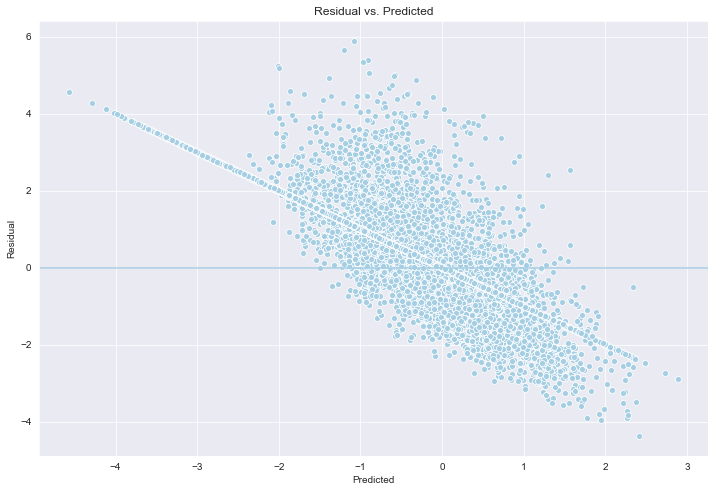

In [14]:
# visualizing homoscedasticity
plt.figure(figsize=(12,8))
sns.scatterplot(x=predictions, y=errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

In [15]:
# statistical tests for homoscedasticity
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 723.853 and p value is 1.95e-159
Levene test statistic value is 326.038 and p value is 8.95e-73


The p-values of both tests are lower than 0.05. The test results reject the null hypothesis which means our errors are heteroscedastic.

### 4. low multicollinearity

In [16]:
corr = weather_df3.corr()
corr.style.background_gradient(cmap='RdBu_r')

Low correlation between explanatory features

### 5. error terms should be uncorrelated with one another

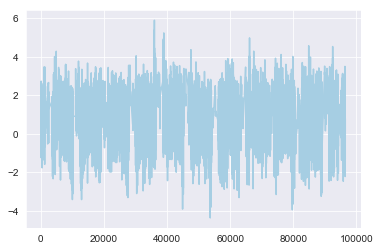

In [17]:
plt.plot(errors)
plt.show()

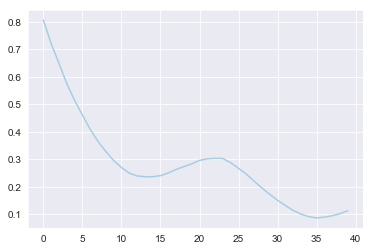

In [18]:
acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

### 6. features shouldn't be correlated with the errors

## Are the estimated coefficients statistically significant?

both coefficients are statistically significant according to the model's summary.

## Are the signs of the estimated coefficients in line with your previous expectations? 
Yes, both humidity and wind speed decrease the apparent temperature difference.

# Troubleshooting 0 values in apparent temperature difference

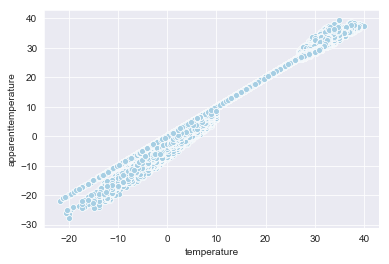

In [19]:
sns.scatterplot(x='temperature', y='apparenttemperature', data=weather_df2)
plt.show()

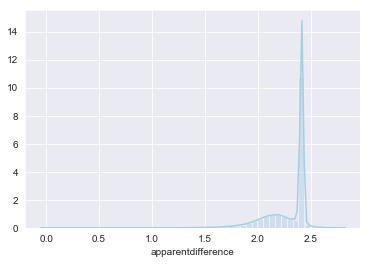

In [20]:
# distribution after using log transofrmation
min_dif = weather_df3['apparentdifference'].min()
sns.distplot(np.log(weather_df3['apparentdifference'] - min_dif + 1))
plt.show()

# options:
1. eliminate data
2. replace with small values and log transform

In [21]:
# How many of the data points have an apparent temperature difference that equals 0?
n = (weather_df2['apparenttemperature'] == weather_df2['temperature']).sum()
print('{} data points with apparent difference equal to 0, which accounts for {:.0f}% of the data'.format(n, n/weather_df2.shape[0]*100))

55776 data points with apparent difference equal to 0, which accounts for 58% of the data


Since the apparent difference 0 values account for more than 50% of the data, eliminating these points would not be a reasonable solution to this problem.

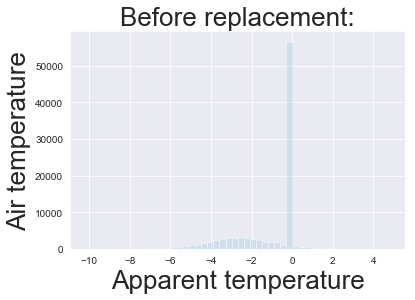

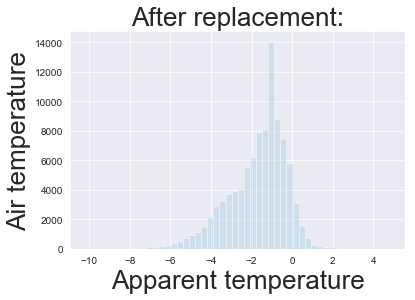

In [22]:
# Replace zero apparent difference with daily apparent difference mean
weather_df3['date'] = weather_df['date']
weather_df3['date'] = pd.to_datetime(weather_df3['date'], format='%Y-%m-%d %H:%M:%s+%Z')
weather_df3 = weather_df3.set_index('date')
weather_df3['apparentdifference'] = weather_df3['apparentdifference'].replace(0, np.nan)
# fill based on mean of date groups. Then, interpolate to fill groups with all Nans
weather_df3['apparentdifference'] = weather_df3['apparentdifference'].fillna(weather_df3.groupby('date')['apparentdifference'].transform('median'))
weather_df3['apparentdifference'] = weather_df3['apparentdifference'].interpolate(method='time')

weather_df3['apparentdifference'].isnull().sum()

#visualize data before and after transformation
sns.distplot(weather_df2['apparenttemperature'] - weather_df2['temperature'], kde=False)
plt.title('Before replacement:', size=26)
plt.xlabel('Apparent temperature', size=26)
plt.ylabel('Air temperature', size=26)
plt.show()

sns.distplot(weather_df3['apparentdifference'][weather_df3['apparentdifference'].notnull()], kde=False)
plt.title('After replacement:', size=26)
plt.xlabel('Apparent temperature', size=26)
plt.ylabel('Air temperature', size=26)
plt.show()

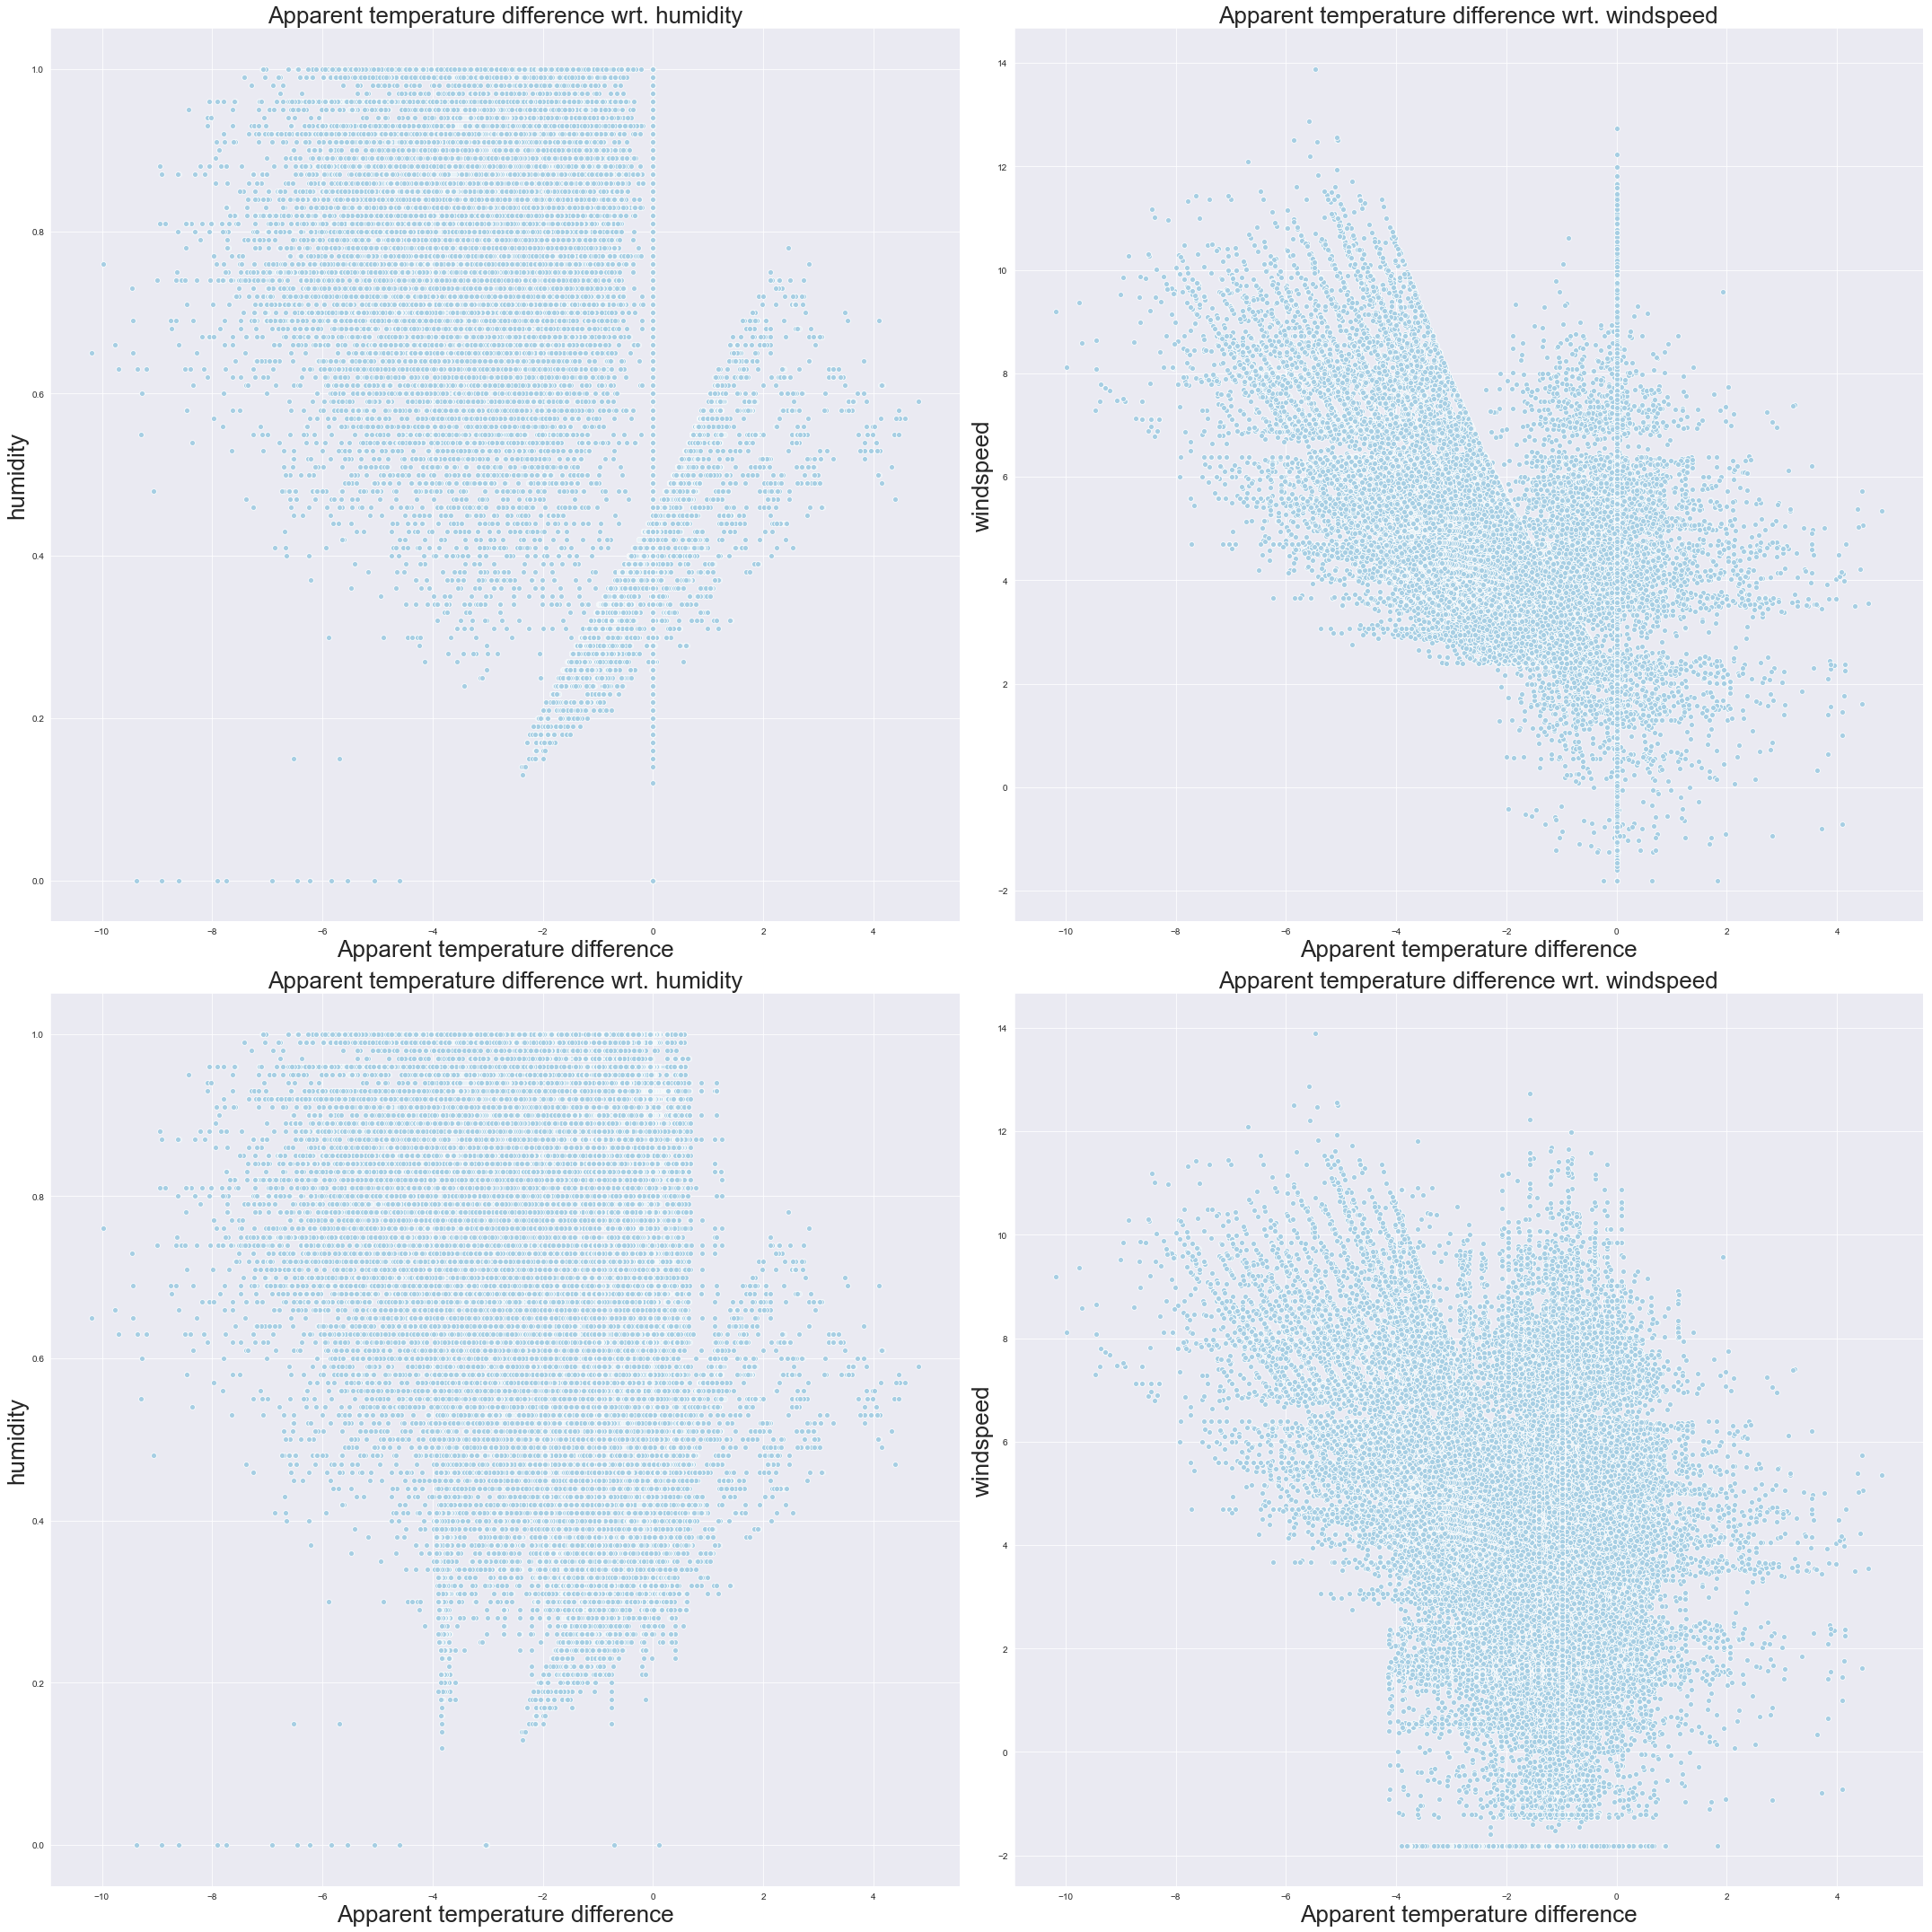

In [23]:
# visualizing the effect of interpolation on scatterplot with explanatory features
plt.figure(figsize=(30,30))

cols = ('humidity', 'windspeed')
for index, col in enumerate(cols):
    plt.subplot(2,2,index+1)
    sns.scatterplot(y=col, x=weather_df2['apparenttemperature']-weather_df2['temperature'], data=weather_df2)
    plt.title('Apparent temperature difference wrt. {}'.format(col), size=26)
    plt.xlabel('Apparent temperature difference', size=26)
    plt.ylabel(col, size=26)
    plt.subplot(2,2,index+3)
    sns.scatterplot(y=col, x='apparentdifference', data=weather_df3)
    plt.title('Apparent temperature difference wrt. {}'.format(col), size=26)
    plt.xlabel('Apparent temperature difference', size=26)
    plt.ylabel(col, size=26)
    
plt.tight_layout()
plt.show()

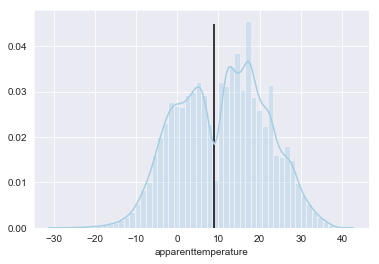

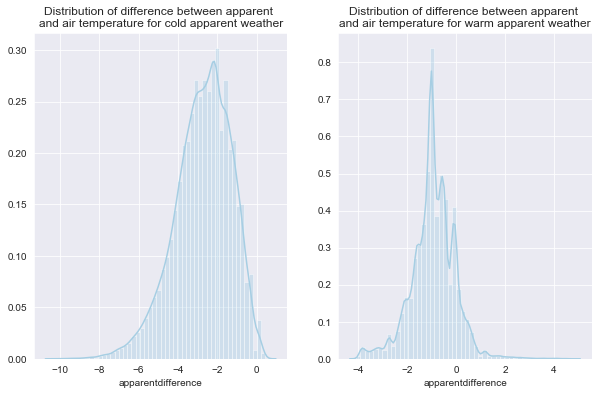

In [24]:
# splitting data based on apparent temperature again and plotting
cutoff = 9
sns.distplot(weather_df2['apparenttemperature'])
plt.vlines(x=cutoff, ymin=0, ymax=0.045)
plt.show()

weather_df3 = weather_df3.reset_index(drop=True)
weather_df2_cold = weather_df3[weather_df2['apparenttemperature'] < cutoff]
weather_df2_warm = weather_df3[weather_df2['apparenttemperature'] >= cutoff]

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
sns.distplot(weather_df2_cold['apparentdifference'])
plt.title('Distribution of difference between apparent \nand air temperature for cold apparent weather')
plt.subplot(1,2,2)
sns.distplot(weather_df2_warm['apparentdifference'])
plt.title('Distribution of difference between apparent \nand air temperature for warm apparent weather')
plt.show()

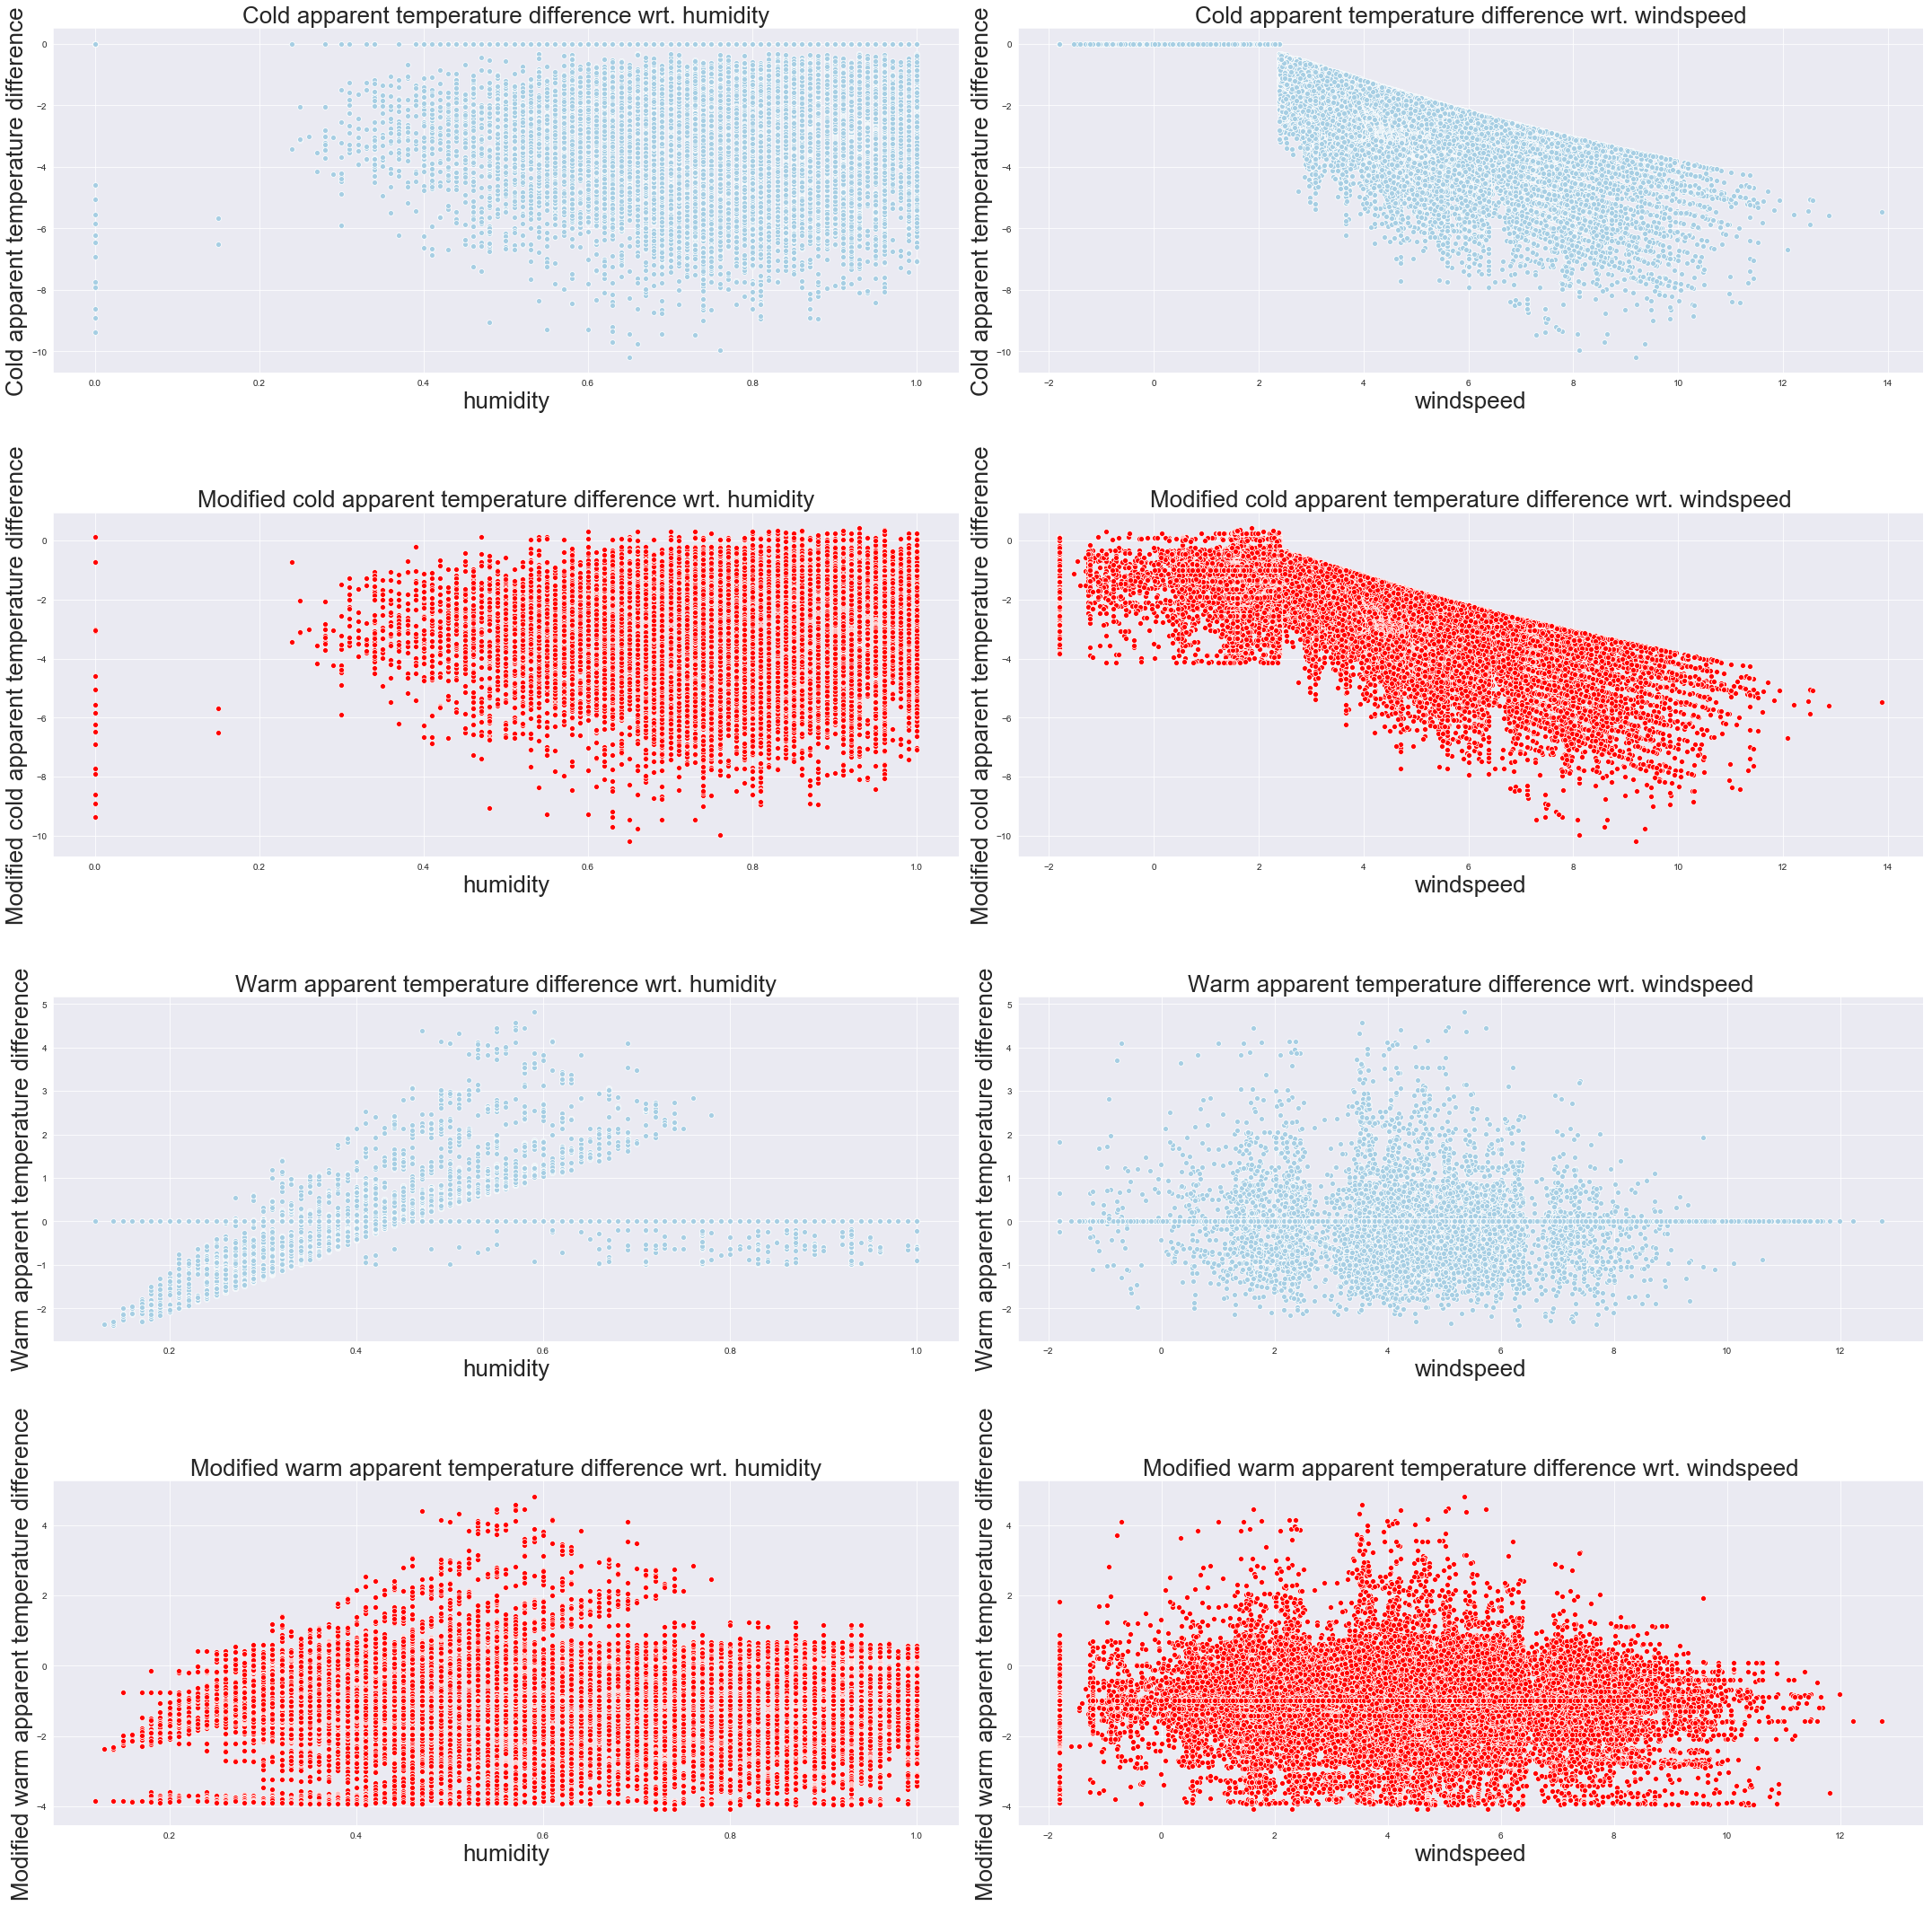

In [34]:
# visualize explanatory features for each subgroup
plt.figure(figsize=(30,30))

cols = ['humidity', 'windspeed']
for index, col in enumerate(cols):
    plt.subplot(4,2,index+1)
    sns.scatterplot(x=col, y='apparentdifference', data=weather_df_cold)
    plt.title('Cold apparent temperature difference wrt. {}'.format(col), size=26)
    plt.ylabel('Cold apparent temperature difference', size=26)
    plt.xlabel(col, size=26)
    
    plt.subplot(4,2,index+3)
    sns.scatterplot(x=col, y='apparentdifference', data=weather_df2_cold, color='r')
    plt.title('Modified cold apparent temperature difference wrt. {}'.format(col), size=26)
    plt.ylabel('Modified cold apparent temperature difference', size=26)
    plt.xlabel(col, size=26)

    plt.subplot(4,2,index+5)
    sns.scatterplot(x=col, y='apparentdifference', data=weather_df_warm)
    plt.title('Warm apparent temperature difference wrt. {}'.format(col), size=26)
    plt.ylabel('Warm apparent temperature difference', size=26)
    plt.xlabel(col, size=26)
    
    plt.subplot(4,2,index+7)
    sns.scatterplot(x=col, y='apparentdifference', data=weather_df2_warm, color='r')
    plt.title('Modified warm apparent temperature difference wrt. {}'.format(col), size=26)
    plt.ylabel('Modified warm apparent temperature difference', size=26)
    plt.xlabel(col, size=26)
plt.tight_layout()
plt.show()

In [35]:
# Bimodel and performance summary
## cold apparent weather
target = weather_df2_cold['apparentdifference']
data = weather_df2_cold[cols]

sm_data = sm.add_constant(data)

results = sm.OLS(target, sm_data).fit()
print('Cold apparent weather model summary:\n',results.summary())

## warm apparent weather
target = weather_df2_warm['apparentdifference']
data = weather_df2_warm[cols]

sm_data = sm.add_constant(data)

results = sm.OLS(target, sm_data).fit()
print('\n**************************************************\nWarm apparent weather model summary:\n',results.summary())

Cold apparent weather model summary:
                             OLS Regression Results                            
Dep. Variable:     apparentdifference   R-squared:                       0.539
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                 2.448e+04
Date:                Fri, 30 Aug 2019   Prob (F-statistic):               0.00
Time:                        01:56:29   Log-Likelihood:                -58262.
No. Observations:               41951   AIC:                         1.165e+05
Df Residuals:                   41948   BIC:                         1.166e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         

## Zero replacement worsened the model performance.
Distribution of humidity vs. apparent difference is severly affected because of this replacement. 

New option: Figure out if the data can be divided based on other criteria to exclude these zero points.

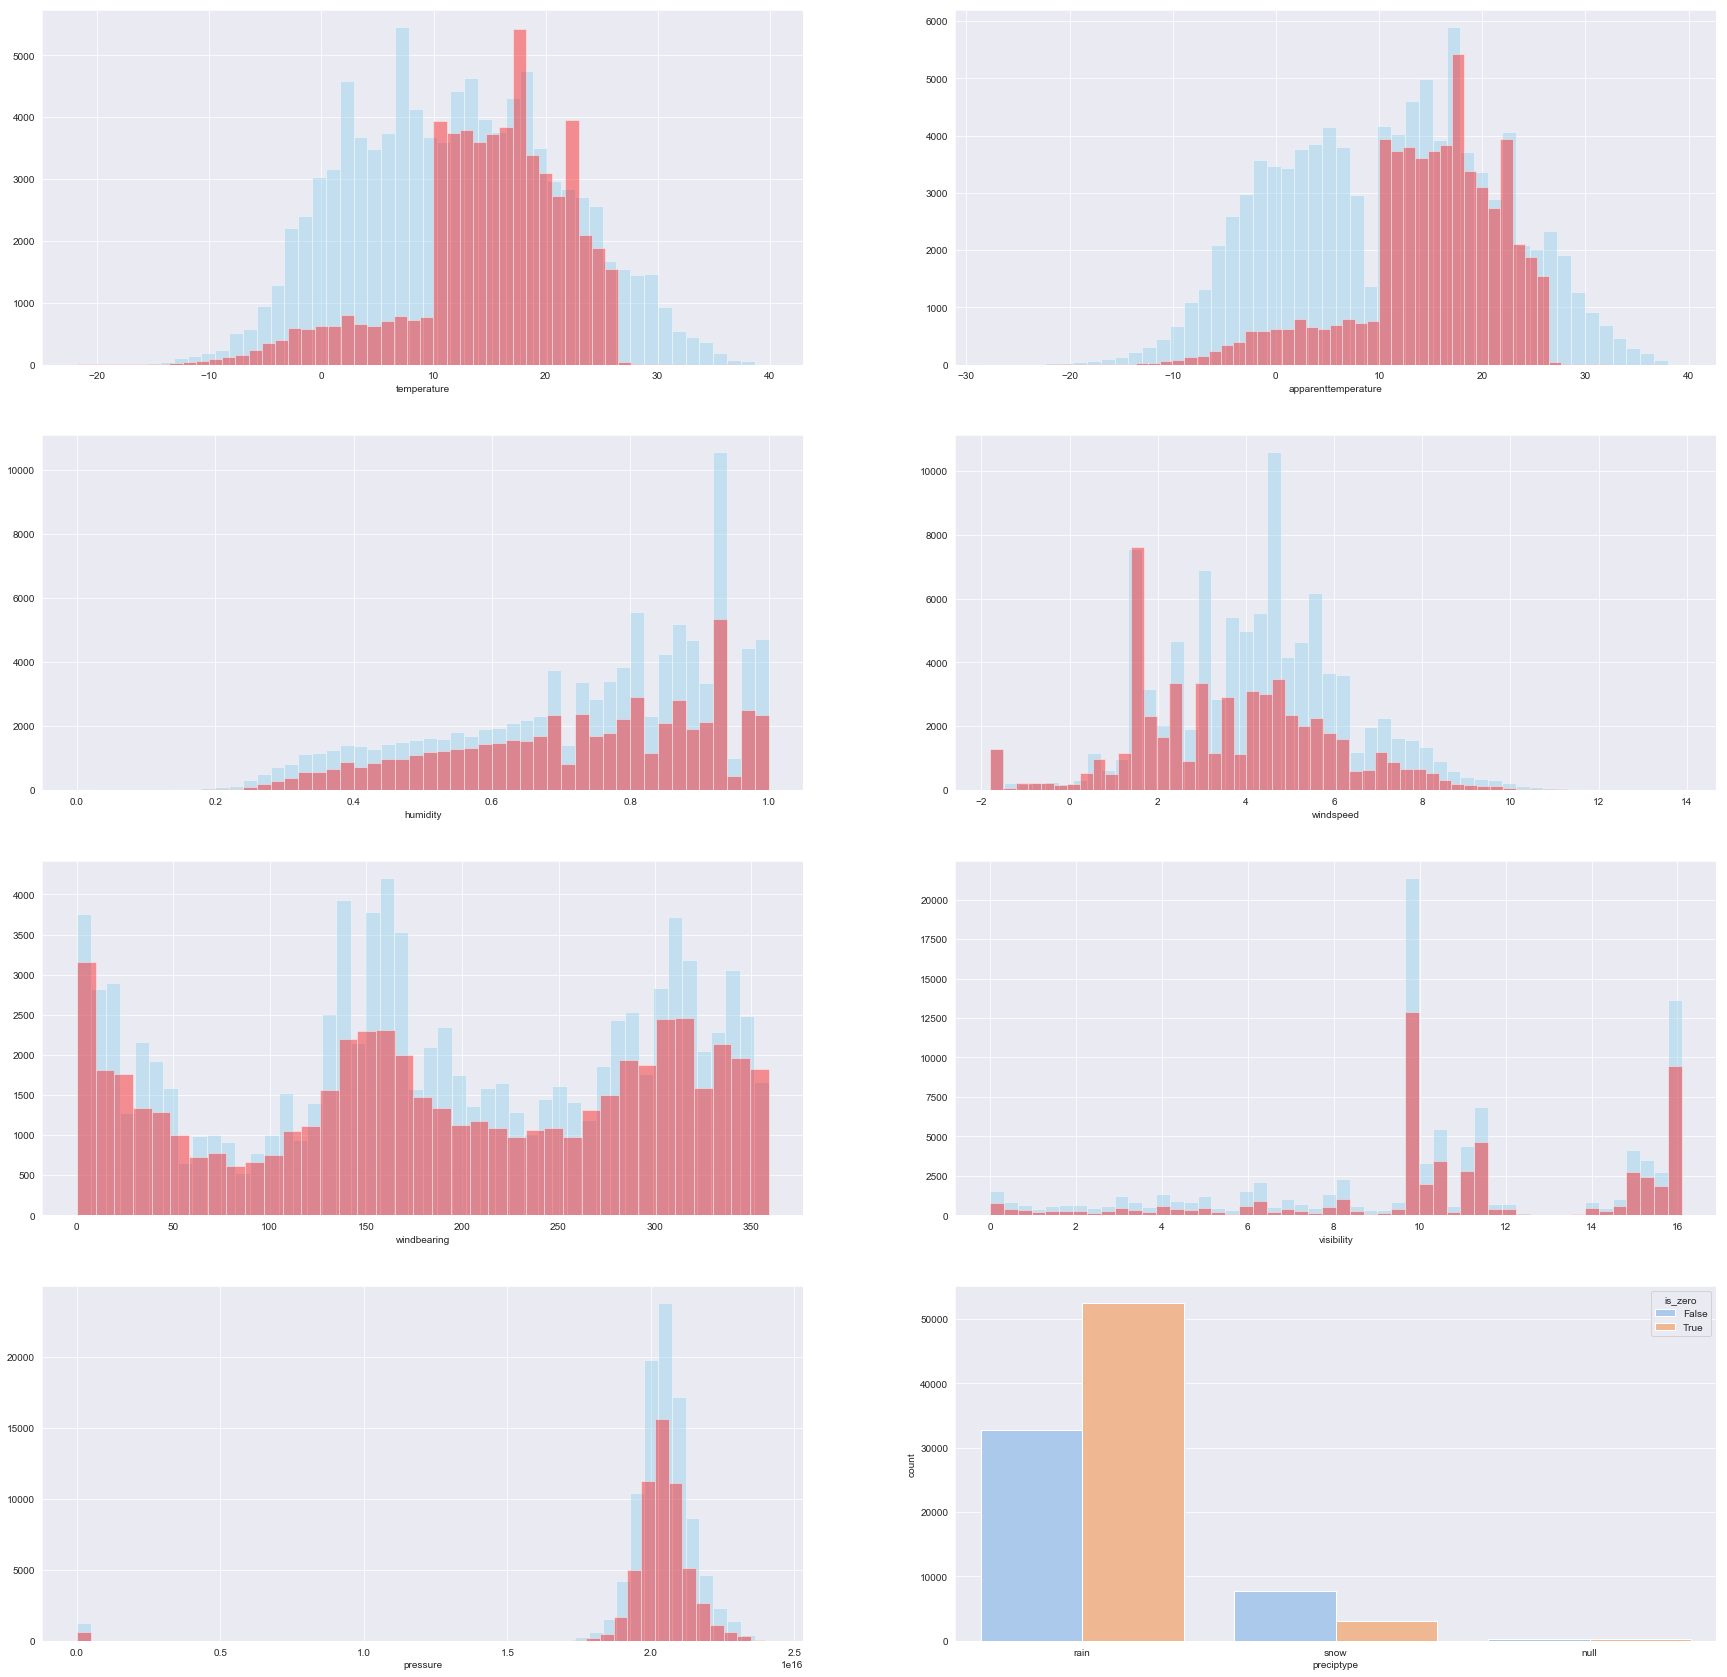

In [96]:
weather_df2['is_zero'] = (weather_df2.apparenttemperature - weather_df2.temperature == 0)

plt.figure(figsize=(30,30))

cols = ['temperature', 'apparenttemperature', 'humidity', 'windspeed', 'windbearing', 'visibility', 'pressure']
for ind, col in enumerate(cols):
    plt.subplot(4,2,ind+1)
    sns.distplot( weather_df2[col], kde=False, color="skyblue", label='Apparent difference')
    sns.distplot( weather_df2.loc[weather_df2['is_zero'],col], kde=False, color="red", label='zeros')

plt.subplot(4,2,8)
sns.countplot(x='preciptype', hue='is_zero', data=weather_df2)
plt.show()

It doesn't seem that the zero apparent difference entries concentrate in a specific category for any variable